# Inter-Annotator Agreement Analysis: LLMs vs Human Annotators

## Overview

This notebook performs a comprehensive statistical analysis to assess the reliability of Large Language Models (LLMs) as annotators for commit classification tasks, compared to human expert annotators. The analysis uses a validation set of 50 Linux kernel commits annotated by 3 human and 7 different LLMs across 4 classification categories (BFC, BPC, PRC, NFC) using a 5-point Likert scale (0-4).

**Key Metrics:**
- **Krippendorff's Alpha (ordinal)**: Measures multi-rater reliability considering the ordinal nature of ratings
- **Cohen's Kappa (weighted)**: Evaluates pairwise agreement between individual LLM and human annotators
- **Confusion Matrices**: Visualizes error patterns comparing LLM predictions against human consensus

**Research Question:** Can LLMs be considered reliable annotators for annotation tasks?

---

## Table of Contents

1. [Import Required Libraries](#1-import-required-libraries)
2. [Load Data](#2-load-data)
3. [Prepare Data for Analysis](#3-prepare-data-for-analysis)
4. [Data Overview](#4-data-overview)
5. [Calculate Krippendorff's Alpha](#5-calculate-krippendorffs-alpha)
6. [Visualize Krippendorff's Alpha](#6-visualize-krippendorffs-alpha)
7. [Calculate Cohen's Kappa](#7-calculate-cohens-kappa)
8. [Visualize Cohen's Kappa](#8-visualize-cohens-kappa)
9. [Confusion Matrices](#9-confusion-matrices)
10. [Statistical Summary](#10-statistical-summary)
11. [Analysis and Conclusions](#11-analysis-and-conclusions)
12. [Export Results](#12-export-results)

---

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import krippendorff
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 2. Load Data

Load all CSV files from the annotator-results folder and combine them into a single dataframe.

In [2]:
# Define paths
data_dir = Path("../data/annotator-results")

# List all CSV files
csv_files = {
    "A": "annotations_A.csv",
    "B": "annotations_B.csv",
    "C": "annotations_C.csv",
    "deepseek-r1_14b": "annotations_ollama_deepseek-r1_14b.csv",
    "mistral_7b": "annotations_ollama_mistral_7b.csv",
    "gemma3_12b": "annotations_ollama_gemma3_12b.csv",
    "qwen3-coder_30b": "annotations_ollama_qwen3-coder_30b.csv",
    "gpt-oss_20b": "annotations_ollama_gpt-oss_20b.csv",
    "codellama_13b": "annotations_ollama_codellama_13b.csv",
    "llama3.1_8b": "annotations_ollama_llama3.1_8b.csv"
}

# Human annotators
human_annotators = ['A', 'B', 'C']

# LLM annotators
llm_annotators = [
    'deepseek-r1_14b',
    'mistral_7b',
    'gemma3_12b',
    'qwen3-coder_30b',
    'gpt-oss_20b',
    'codellama_13b',
    'llama3.1_8b'
]

# Load all data
all_data = []
for annotator_name, filename in csv_files.items():
    filepath = data_dir / filename
    if filepath.exists():
        df = pd.read_csv(filepath)
        df['annotator_id'] = annotator_name
        all_data.append(df)
        print(f"✓ Loaded {filename}: {len(df)} annotations")
    else:
        print(f"✗ File not found: {filename}")

# Combine all data
combined_df = pd.concat(all_data, ignore_index=True)
print(f"\nTotal annotations loaded: {len(combined_df)}")
print(f"Unique annotators: {combined_df['annotator_id'].nunique()}")
print(f"Unique commits: {combined_df['hash'].nunique()}")

✓ Loaded annotations_A.csv: 911 annotations
✓ Loaded annotations_B.csv: 1000 annotations
✓ Loaded annotations_C.csv: 911 annotations
✓ Loaded annotations_ollama_deepseek-r1_14b.csv: 50 annotations
✓ Loaded annotations_ollama_mistral_7b.csv: 50 annotations
✓ Loaded annotations_ollama_gemma3_12b.csv: 50 annotations
✓ Loaded annotations_ollama_qwen3-coder_30b.csv: 50 annotations
✓ Loaded annotations_ollama_gpt-oss_20b.csv: 50 annotations
✓ Loaded annotations_ollama_codellama_13b.csv: 50 annotations
✓ Loaded annotations_ollama_llama3.1_8b.csv: 50 annotations

Total annotations loaded: 3172
Unique annotators: 10
Unique commits: 1000


## 3. Prepare Data for Analysis

Filter data to only include commits that have annotations from all annotators (the validation set of 50 commits).

In [3]:
# Relevant columns for analysis
classification_cols = ['bfc', 'bpc', 'prc', 'nfc']

# Clean the data - ensure hash column is properly named
if 'hash' not in combined_df.columns and 'commit_hash' in combined_df.columns:
    combined_df['hash'] = combined_df['commit_hash']

# Count annotations per commit
commits_per_annotator = combined_df.groupby('hash')['annotator_id'].nunique()

# Find commits annotated by all 10 annotators (3 humans + 7 LLMs)
expected_annotators = len(human_annotators) + len(llm_annotators)
fully_annotated_commits = commits_per_annotator[commits_per_annotator == expected_annotators].index.tolist()

print(f"Commits with all {expected_annotators} annotations: {len(fully_annotated_commits)}")

# Filter to only fully annotated commits
validation_df = combined_df[combined_df['hash'].isin(fully_annotated_commits)].copy()

print(f"\nValidation dataset:")
print(f"  Unique commits: {validation_df['hash'].nunique()}")
print(f"  Annotators:")
for annotator in sorted(validation_df['annotator_id'].unique()):
    print(f"    - {annotator}")

Commits with all 10 annotations: 50

Validation dataset:
  Unique commits: 50
  Annotators:
    - A
    - B
    - C
    - codellama_13b
    - deepseek-r1_14b
    - gemma3_12b
    - gpt-oss_20b
    - llama3.1_8b
    - mistral_7b
    - qwen3-coder_30b


## 4. Data Overview

Display basic statistics and distribution of annotations.

In [4]:
# Display first few rows
print("Sample of validation data:")
display(validation_df[['hash', 'annotator_id'] + classification_cols].head(5))

# Summary statistics per classification category
print("\nDistribution of annotations by category:")
for col in classification_cols:
    print(f"\n{col.upper()}:")
    print(validation_df.groupby('annotator_id')[col].value_counts().unstack(fill_value=0))

Sample of validation data:


,hash,annotator_id,bfc,bpc,prc,nfc
6,3044a4f271,A,0,0,4,0
25,e1553351d7,A,0,0,4,0
27,2fadc6ea4a,A,0,0,3,0
30,805a3ebed5,A,0,0,4,0
32,9b51d9d866,A,0,0,4,0



Distribution of annotations by category:

BFC:
bfc               0  1  2  3   4
annotator_id                    
A                40  0  0  2   8
B                36  0  1  3  10
C                40  0  0  0  10
codellama_13b    38  1  0  5   6
deepseek-r1_14b  37  0  1  7   5
gemma3_12b       37  1  3  3   6
gpt-oss_20b      36  0  0  0  14
llama3.1_8b      38  0  0  0  12
mistral_7b       45  0  0  1   4
qwen3-coder_30b  35  0  2  5   8

BPC:
bpc               0   1   2   3   4
annotator_id                       
A                43   1   2   3   1
B                34   1   0   4  11
C                39   1   0   2   8
codellama_13b    18  19   5   8   0
deepseek-r1_14b  24  14   9   3   0
gemma3_12b       10  37   3   0   0
gpt-oss_20b      19   8  11  10   2
llama3.1_8b      14   1  30   5   0
mistral_7b       21   2  22   5   0
qwen3-coder_30b  19  15  14   2   0

PRC:
prc               0   1  2   3   4
annotator_id                      
A                16   1  0   6  27
B      

In [5]:
# Calculate commits with 2+ categories rated >= 1 for each annotator
print("\n" + "="*80)
print("Commits with at least 2 categories rated ≥ 1 (per annotator):")
print("="*80)

multi_category_results = []

for annotator in sorted(validation_df['annotator_id'].unique()):
    annotator_data = validation_df[validation_df['annotator_id'] == annotator]
    
    # For each commit, count how many categories have value >= 1
    commits_with_multi_categories = 0
    
    for commit_hash in annotator_data['hash'].unique():
        commit_row = annotator_data[annotator_data['hash'] == commit_hash].iloc[0]
        
        # Count categories with rating >= 1
        categories_rated_high = sum([
            1 for col in classification_cols 
            if commit_row[col] >= 1
        ])
        
        if categories_rated_high >= 2:
            commits_with_multi_categories += 1
    
    total_commits = len(annotator_data['hash'].unique())
    percentage = (commits_with_multi_categories / total_commits * 100) if total_commits > 0 else 0
    
    multi_category_results.append({
        'Annotator': annotator,
        'Commits_2+_Categories': commits_with_multi_categories,
        'Total_Commits': total_commits,
        'Percentage': percentage
    })
    
    print(f"{annotator:20s}: {commits_with_multi_categories:2d}/{total_commits} commits ({percentage:5.1f}%)")

# Create summary dataframe
multi_category_df = pd.DataFrame(multi_category_results)
multi_category_df = multi_category_df.sort_values('Commits_2+_Categories', ascending=False)

print("\n" + "="*80)
print("Summary (sorted by count):")
print("="*80)
display(multi_category_df)


Commits with at least 2 categories rated ≥ 1 (per annotator):
A                   :  8/50 commits ( 16.0%)
B                   : 13/50 commits ( 26.0%)
C                   :  8/50 commits ( 16.0%)
codellama_13b       : 26/50 commits ( 52.0%)
deepseek-r1_14b     : 28/50 commits ( 56.0%)
deepseek-r1_14b     : 28/50 commits ( 56.0%)
gemma3_12b          : 41/50 commits ( 82.0%)
gemma3_12b          : 41/50 commits ( 82.0%)
gpt-oss_20b         : 30/50 commits ( 60.0%)
llama3.1_8b         : 45/50 commits ( 90.0%)
mistral_7b          : 38/50 commits ( 76.0%)
qwen3-coder_30b     : 32/50 commits ( 64.0%)

Summary (sorted by count):
gpt-oss_20b         : 30/50 commits ( 60.0%)
llama3.1_8b         : 45/50 commits ( 90.0%)
mistral_7b          : 38/50 commits ( 76.0%)
qwen3-coder_30b     : 32/50 commits ( 64.0%)

Summary (sorted by count):


,Annotator,Commits_2+_Categories,Total_Commits,Percentage
7,llama3.1_8b,45,50,90.0
5,gemma3_12b,41,50,82.0
8,mistral_7b,38,50,76.0
9,qwen3-coder_30b,32,50,64.0
6,gpt-oss_20b,30,50,60.0
4,deepseek-r1_14b,28,50,56.0
3,codellama_13b,26,50,52.0
1,B,13,50,26.0
0,A,8,50,16.0
2,C,8,50,16.0


## 5. Calculate Krippendorff's Alpha

Krippendorff's Alpha measures reliability of agreement among multiple raters for ordinal data.
- Alpha ≥ 0.800: Good reliability
- 0.667 ≤ Alpha < 0.800: Tentative conclusions
- Alpha < 0.667: Insufficient reliability

#### How Krippendorff's Alpha Works with Ordinal Data

When we specify `level_of_measurement='ordinal'`, the algorithm understands that:

- **0 vs 4**: Maximum disagreement (they are at opposite extremes)
- **3 vs 4**: Minimal disagreement (only 1 point difference)
- **4 vs 4**: Perfect agreement (same score)

##### Calculating Ordinal Distances

For ordinal data, Krippendorff's Alpha calculates the **distance** considering:

```python
# Simplified example of how ordinal distances are calculated
distance(3, 4) = small      # Close neighbors
distance(0, 4) = maximum    # Opposite extremes
distance(2, 2) = 0          # Perfect agreement
```

##### Conceptual Formula

```
Alpha = 1 - (observed_disagreement / expected_disagreement_by_chance)
```

**Where:**
- If everyone rates the same (4,4,4,4) → disagreement = 0 → **Alpha = 1.0** (perfect agreement)
- If differences are small (3,4,4,3) → low disagreement → **Alpha ≈ 0.8-0.9** (good agreement)
- If there's high variation (0,2,3,4) → high disagreement → **Alpha ≈ 0.3-0.5** (poor agreement)
- If it's random → disagreement = expected → **Alpha ≈ 0** (no agreement)

We calculate alpha for each LLM combined with the 3 human annotators (4 raters total).

In [6]:
def calculate_krippendorff_alpha(df, annotators, classification_col):
    """
    Calculate Krippendorff's Alpha for given annotators on a specific classification.
    
    Args:
        df: DataFrame with annotations
        annotators: List of annotator IDs to include
        classification_col: Column name (bfc, bpc, prc, nfc)
    
    Returns:
        Krippendorff's Alpha value
    """
    # Filter to selected annotators
    subset = df[df['annotator_id'].isin(annotators)].copy()
    
    # Pivot: rows=commits, columns=annotators, values=ratings
    pivot = subset.pivot(index='hash', columns='annotator_id', values=classification_col)
    
    # Convert to reliability matrix format (raters x items)
    # Krippendorff expects: rows=raters, columns=items
    reliability_matrix = pivot.T.values
    
    # Calculate alpha for ordinal data
    try:
        alpha = krippendorff.alpha(reliability_data=reliability_matrix, level_of_measurement='ordinal')
        return alpha
    except:
        return np.nan

# Calculate Krippendorff's Alpha for each LLM + 3 humans
krippendorff_results = []

# Add inter-human agreement as baseline
for category in classification_cols:
    alpha = calculate_krippendorff_alpha(validation_df, human_annotators, category)
    krippendorff_results.append({
        'LLM': 'inter-human-it1',
        'Category': category.upper(),
        'Krippendorff_Alpha': alpha
    })

# Add LLM + 3 humans results
for llm in llm_annotators:
    for category in classification_cols:
        # Combine LLM with 3 human annotators
        annotators_group = human_annotators + [llm]
        alpha = calculate_krippendorff_alpha(validation_df, annotators_group, category)
        
        krippendorff_results.append({
            'LLM': llm,
            'Category': category.upper(),
            'Krippendorff_Alpha': alpha
        })

# Create results dataframe
krippendorff_df = pd.DataFrame(krippendorff_results)

# Pivot for better visualization
krippendorff_pivot = krippendorff_df.pivot(index='LLM', columns='Category', values='Krippendorff_Alpha')

print("Krippendorff's Alpha - Ranked by average:")
print("(inter-human = agreement among 3 human annotators A, B, C)")
print("(LLM models = agreement between LLM + 3 human annotators)")
# Calculate average alpha per LLM
krippendorff_pivot['Average'] = krippendorff_pivot.mean(axis=1)
krippendorff_sorted = krippendorff_pivot.sort_values('Average', ascending=False)

display(krippendorff_sorted.round(3))

Krippendorff's Alpha - Ranked by average:
(inter-human = agreement among 3 human annotators A, B, C)
(LLM models = agreement between LLM + 3 human annotators)


Category,BFC,BPC,NFC,PRC,Average
LLM,,,,,
inter-human-it1,0.842,0.448,0.798,0.723,0.703
qwen3-coder_30b,0.802,0.287,0.777,0.652,0.630
deepseek-r1_14b,0.750,0.356,0.748,0.650,0.626
gpt-oss_20b,0.746,0.314,0.726,0.707,0.623
gemma3_12b,0.802,0.234,0.782,0.585,0.601
llama3.1_8b,0.772,0.181,0.758,0.524,0.559
mistral_7b,0.673,0.242,0.689,0.547,0.538
codellama_13b,0.666,0.144,0.537,0.490,0.459


## 6. Visualize Krippendorff's Alpha

Create heatmap and bar charts to visualize agreement levels.

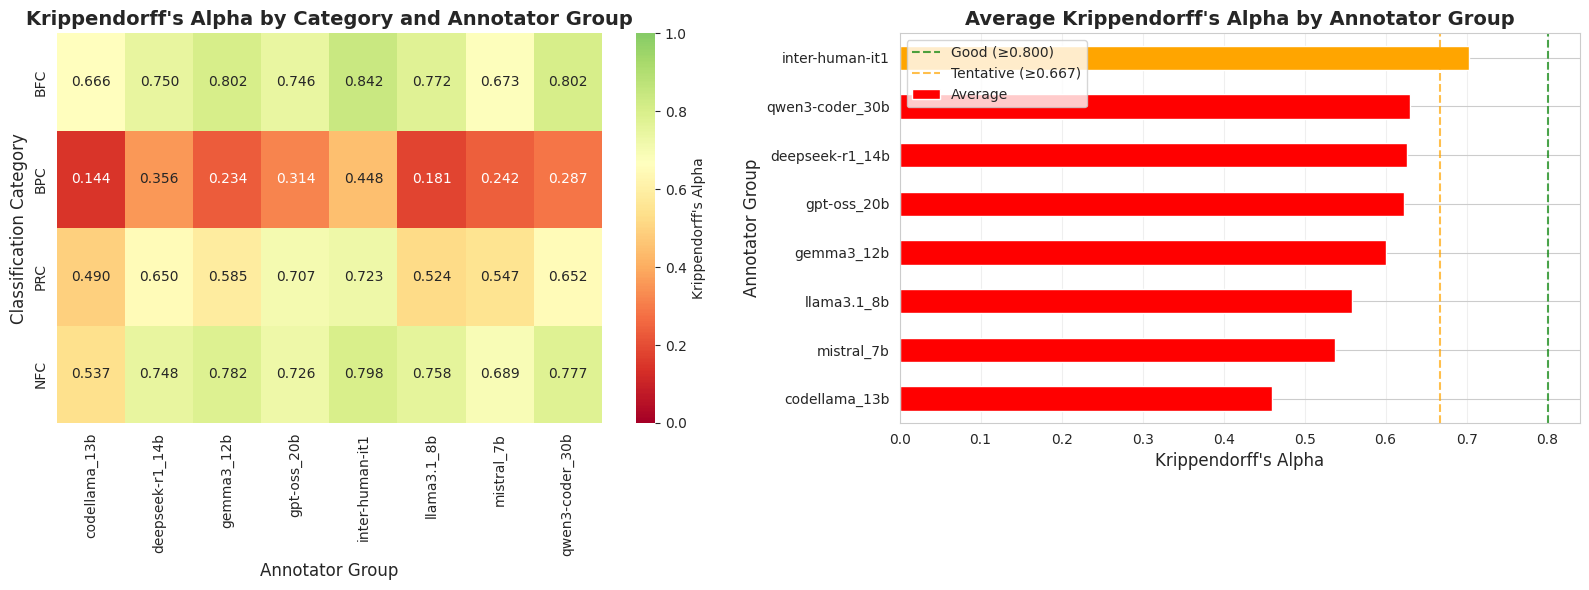

In [7]:
# Heatmap of Krippendorff's Alpha
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap - use uppercase column names
category_cols_upper = [col.upper() for col in classification_cols]
sns.heatmap(krippendorff_pivot[category_cols_upper].T, 
            annot=True, fmt='.3f', cmap='RdYlGn', center=0.667,
            vmin=0, vmax=1, cbar_kws={'label': "Krippendorff's Alpha"},
            ax=ax1)
ax1.set_title("Krippendorff's Alpha by Category and Annotator Group", fontsize=14, fontweight='bold')
ax1.set_xlabel('Annotator Group', fontsize=12)
ax1.set_ylabel('Classification Category', fontsize=12)

# Bar chart of average alpha
avg_alpha = krippendorff_pivot['Average'].sort_values(ascending=True)
colors = ['blue' if idx == 'inter-human' else 'green' if x >= 0.800 else 'orange' if x >= 0.667 else 'red' 
          for idx, x in zip(avg_alpha.index, avg_alpha.values)]
avg_alpha.plot(kind='barh', ax=ax2, color=colors)
ax2.set_title('Average Krippendorff\'s Alpha by Annotator Group', fontsize=14, fontweight='bold')
ax2.set_xlabel("Krippendorff's Alpha", fontsize=12)
ax2.set_ylabel('Annotator Group', fontsize=12)
ax2.axvline(x=0.800, color='green', linestyle='--', label='Good (≥0.800)', alpha=0.7)
ax2.axvline(x=0.667, color='orange', linestyle='--', label='Tentative (≥0.667)', alpha=0.7)
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/krippendorff_alpha_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Calculate Cohen's Kappa

Cohen's Kappa measures pairwise agreement between two raters.
- Kappa > 0.80: Almost perfect agreement
- 0.60-0.80: Substantial agreement
- 0.40-0.60: Moderate agreement
- 0.20-0.40: Fair agreement
- < 0.20: Slight/poor agreement

#### How Cohen's Kappa Works with Ordinal Data

Cohen's Kappa with `weights='linear'`, which works similarly to Krippendorff's Alpha for ordinal data:

```python
kappa = cohen_kappa_score(..., weights='linear')
```

**`weights='linear'`** means that:
- 1 point difference (3 vs 4) → small penalty
- 2 point difference (2 vs 4) → medium penalty
- 4 point difference (0 vs 4) → maximum penalty

##### Interpreting Results

If in your results you see:
- **Alpha = 0.85**: Although there may be some ±1 point differences, there is very good overall agreement
- **Alpha = 0.50**: There are significant differences (±2-3 points) or much inconsistency
- **Alpha = 0.20**: Annotators are rating very differently

We calculate kappa for each LLM vs each human annotator.

In [8]:
def calculate_cohens_kappa(df, annotator1, annotator2, classification_col):
    """
    Calculate Cohen's Kappa for two annotators on a specific classification.
    
    Args:
        df: DataFrame with annotations
        annotator1: First annotator ID
        annotator2: Second annotator ID
        classification_col: Column name (bfc, bpc, prc, nfc)
    
    Returns:
        Cohen's Kappa value
    """
    # Get ratings from both annotators
    df1 = df[df['annotator_id'] == annotator1][['hash', classification_col]].set_index('hash')
    df2 = df[df['annotator_id'] == annotator2][['hash', classification_col]].set_index('hash')
    
    # Merge on commit hash
    merged = df1.join(df2, lsuffix='_1', rsuffix='_2', how='inner')
    
    # Calculate kappa
    try:
        kappa = cohen_kappa_score(merged.iloc[:, 0], merged.iloc[:, 1], weights='linear')
        return kappa
    except:
        return np.nan

# Calculate Cohen's Kappa for all LLM-human pairs
cohens_kappa_results = []

for llm in llm_annotators:
    for human in human_annotators:
        for category in classification_cols:
            kappa = calculate_cohens_kappa(validation_df, llm, human, category)
            
            cohens_kappa_results.append({
                'LLM': llm,
                'Human': human,
                'Category': category.upper(),
                'Cohens_Kappa': kappa
            })

# Create results dataframe
cohens_kappa_df = pd.DataFrame(cohens_kappa_results)

# Calculate average kappa per LLM-human pair across all categories
avg_kappa_per_pair = cohens_kappa_df.groupby(['LLM', 'Human'])['Cohens_Kappa'].mean().reset_index()
avg_kappa_pivot = avg_kappa_per_pair.pivot(index='LLM', columns='Human', values='Cohens_Kappa')

print("Average Cohen's Kappa across all categories (BFC, BPC, PRC, NFC) - Ranked by average Cohen's Kappa:")
# Calculate overall average per LLM
avg_kappa_pivot['Average'] = avg_kappa_pivot.mean(axis=1)
cohens_sorted = avg_kappa_pivot.sort_values('Average', ascending=False)

display(cohens_sorted.round(3))

Average Cohen's Kappa across all categories (BFC, BPC, PRC, NFC) - Ranked by average Cohen's Kappa:


Human,A,B,C,Average
LLM,,,,
gpt-oss_20b,0.513,0.527,0.559,0.533
deepseek-r1_14b,0.546,0.449,0.509,0.501
qwen3-coder_30b,0.521,0.463,0.512,0.499
gemma3_12b,0.516,0.434,0.493,0.481
llama3.1_8b,0.401,0.396,0.402,0.400
mistral_7b,0.325,0.293,0.325,0.315
codellama_13b,0.162,0.238,0.176,0.192


## 8. Visualize Cohen's Kappa

Create detailed visualizations for pairwise agreement.

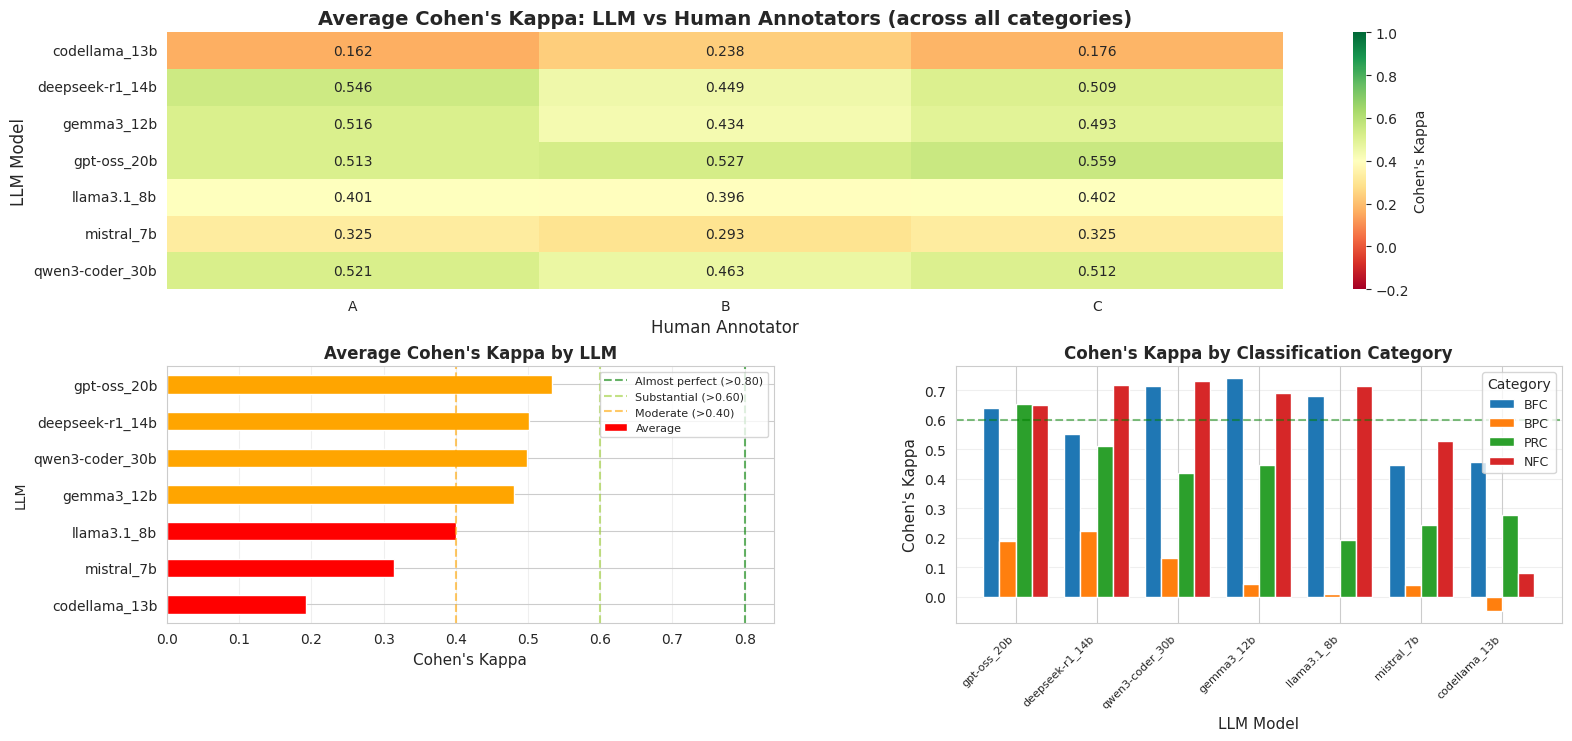

In [9]:
# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Heatmap of average kappa per LLM-human pair
ax1 = fig.add_subplot(gs[0, :])
sns.heatmap(avg_kappa_pivot[human_annotators], annot=True, fmt='.3f', 
            cmap='RdYlGn', center=0.4, vmin=-0.2, vmax=1.0,
            cbar_kws={'label': "Cohen's Kappa"},
            ax=ax1)
ax1.set_title("Average Cohen's Kappa: LLM vs Human Annotators (across all categories)", 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Human Annotator', fontsize=12)
ax1.set_ylabel('LLM Model', fontsize=12)

# 2. Bar chart of average kappa per LLM
ax2 = fig.add_subplot(gs[1, 0])
avg_per_llm = avg_kappa_pivot['Average'].sort_values(ascending=True)
colors = ['green' if x > 0.80 else 'yellowgreen' if x > 0.60 else 'orange' if x > 0.40 else 'red' for x in avg_per_llm]
avg_per_llm.plot(kind='barh', ax=ax2, color=colors)
ax2.set_title('Average Cohen\'s Kappa by LLM', fontsize=12, fontweight='bold')
ax2.set_xlabel("Cohen's Kappa", fontsize=11)
ax2.axvline(x=0.80, color='green', linestyle='--', label='Almost perfect (>0.80)', alpha=0.6)
ax2.axvline(x=0.60, color='yellowgreen', linestyle='--', label='Substantial (>0.60)', alpha=0.6)
ax2.axvline(x=0.40, color='orange', linestyle='--', label='Moderate (>0.40)', alpha=0.6)
ax2.legend(fontsize=8)
ax2.grid(axis='x', alpha=0.3)

# 3. Kappa by category (BFC, BPC, PRC, NFC)
ax3 = fig.add_subplot(gs[1, 1])
category_avg = cohens_kappa_df.groupby(['LLM', 'Category'])['Cohens_Kappa'].mean().reset_index()
category_pivot = category_avg.pivot(index='LLM', columns='Category', values='Cohens_Kappa')
category_pivot['Average'] = category_pivot.mean(axis=1)
category_sorted = category_pivot.sort_values('Average', ascending=False)

x = np.arange(len(category_sorted))
width = 0.2
for i, cat in enumerate(classification_cols):
    ax3.bar(x + i*width, category_sorted[cat.upper()], width, label=cat.upper())

ax3.set_xlabel('LLM Model', fontsize=11)
ax3.set_ylabel("Cohen's Kappa", fontsize=11)
ax3.set_title('Cohen\'s Kappa by Classification Category', fontsize=12, fontweight='bold')
ax3.set_xticks(x + width * 1.5)
ax3.set_xticklabels(category_sorted.index, rotation=45, ha='right', fontsize=8)
ax3.legend(title='Category', fontsize=9)
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=0.60, color='green', linestyle='--', alpha=0.5)

## 9. Confusion Matrices

Generate confusion matrices for each LLM vs consensus human annotation (majority vote).

#### What Are They?

Confusion matrices show how LLM ratings compare with **human consensus** (majority vote from the 3 human annotators A, B, C).

#### Matrix Structure

```
                    LLM Rating (Prediction)
                 0    1    2    3    4
              ┌─────────────────────────┐
Human      0  │ TP   FN   FN   FN   FN  │
Consensus  1  │ FP   TP   FN   FN   FN  │
(Ground    2  │ FP   FP   TP   FN   FN  │
Truth)     3  │ FP   FP   FP   TP   FN  │
           4  │ FP   FP   FP   FP   TP  │
              └─────────────────────────┘
```

##### Matrix Elements

- **Rows**: What humans decided by majority vote (ground truth value)
- **Columns**: What the LLM rated (predicted value)
- **Main diagonal** (0-0, 1-1, 2-2, 3-3, 4-4): Perfect agreements
- **Off-diagonal**: Disagreements

##### Practical Example

Suppose this matrix for **BFC** with an LLM:

```
Human\LLM    0    1    2    3    4
    0       [8]   2    0    0    0
    1        1   [5]   3    1    0
    2        0    2   [6]   2    0
    3        0    0    1   [4]   1
    4        0    0    0    1   [3]
```

##### Interpretation:

**Row 0 (Humans said 0):**
- 8 times: LLM also said 0 ✅ (perfect agreement)
- 2 times: LLM said 1 ❌ (error of +1)
- Total: 10 commits classified by humans as 0

**Row 2 (Humans said 2):**
- 6 times: LLM also said 2 ✅ (perfect agreement)
- 2 times: LLM said 1 ❌ (underestimated by 1)
- 2 times: LLM said 3 ❌ (overestimated by 1)
- Total: 10 commits classified by humans as 2

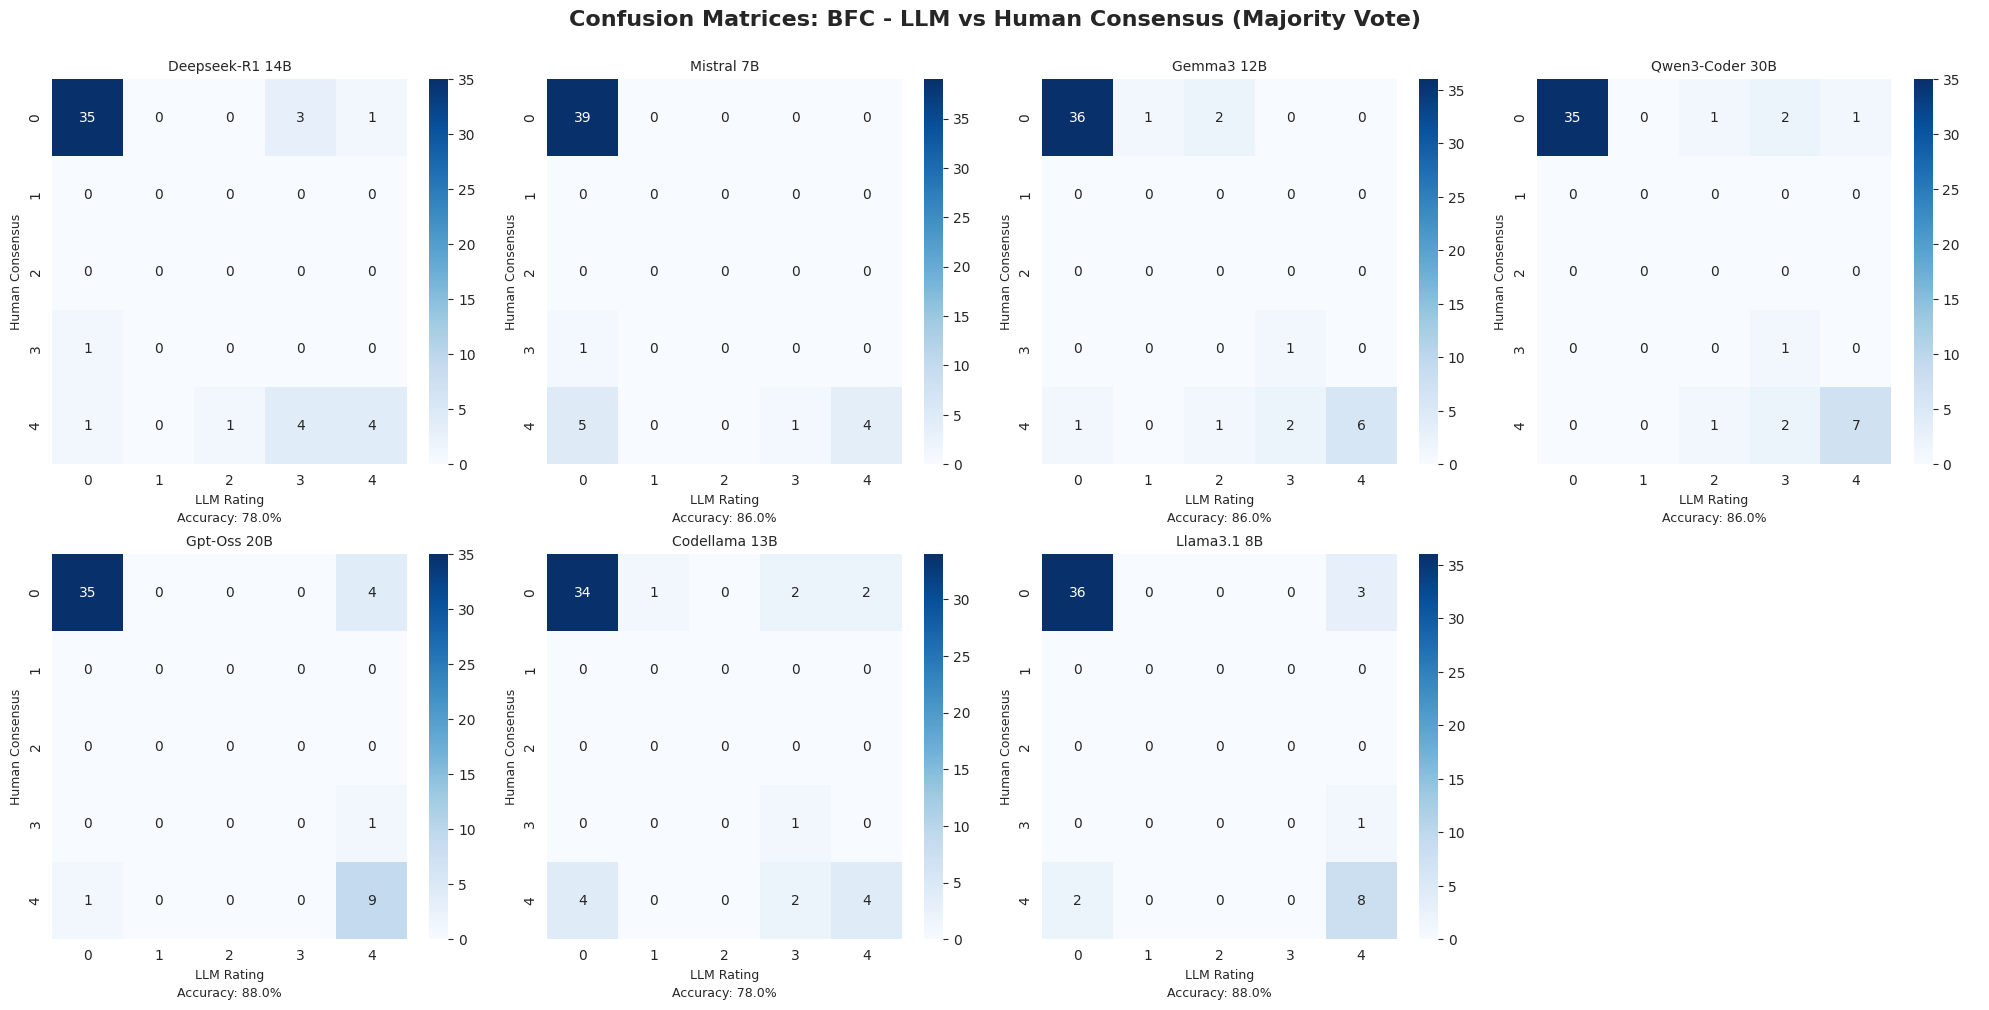

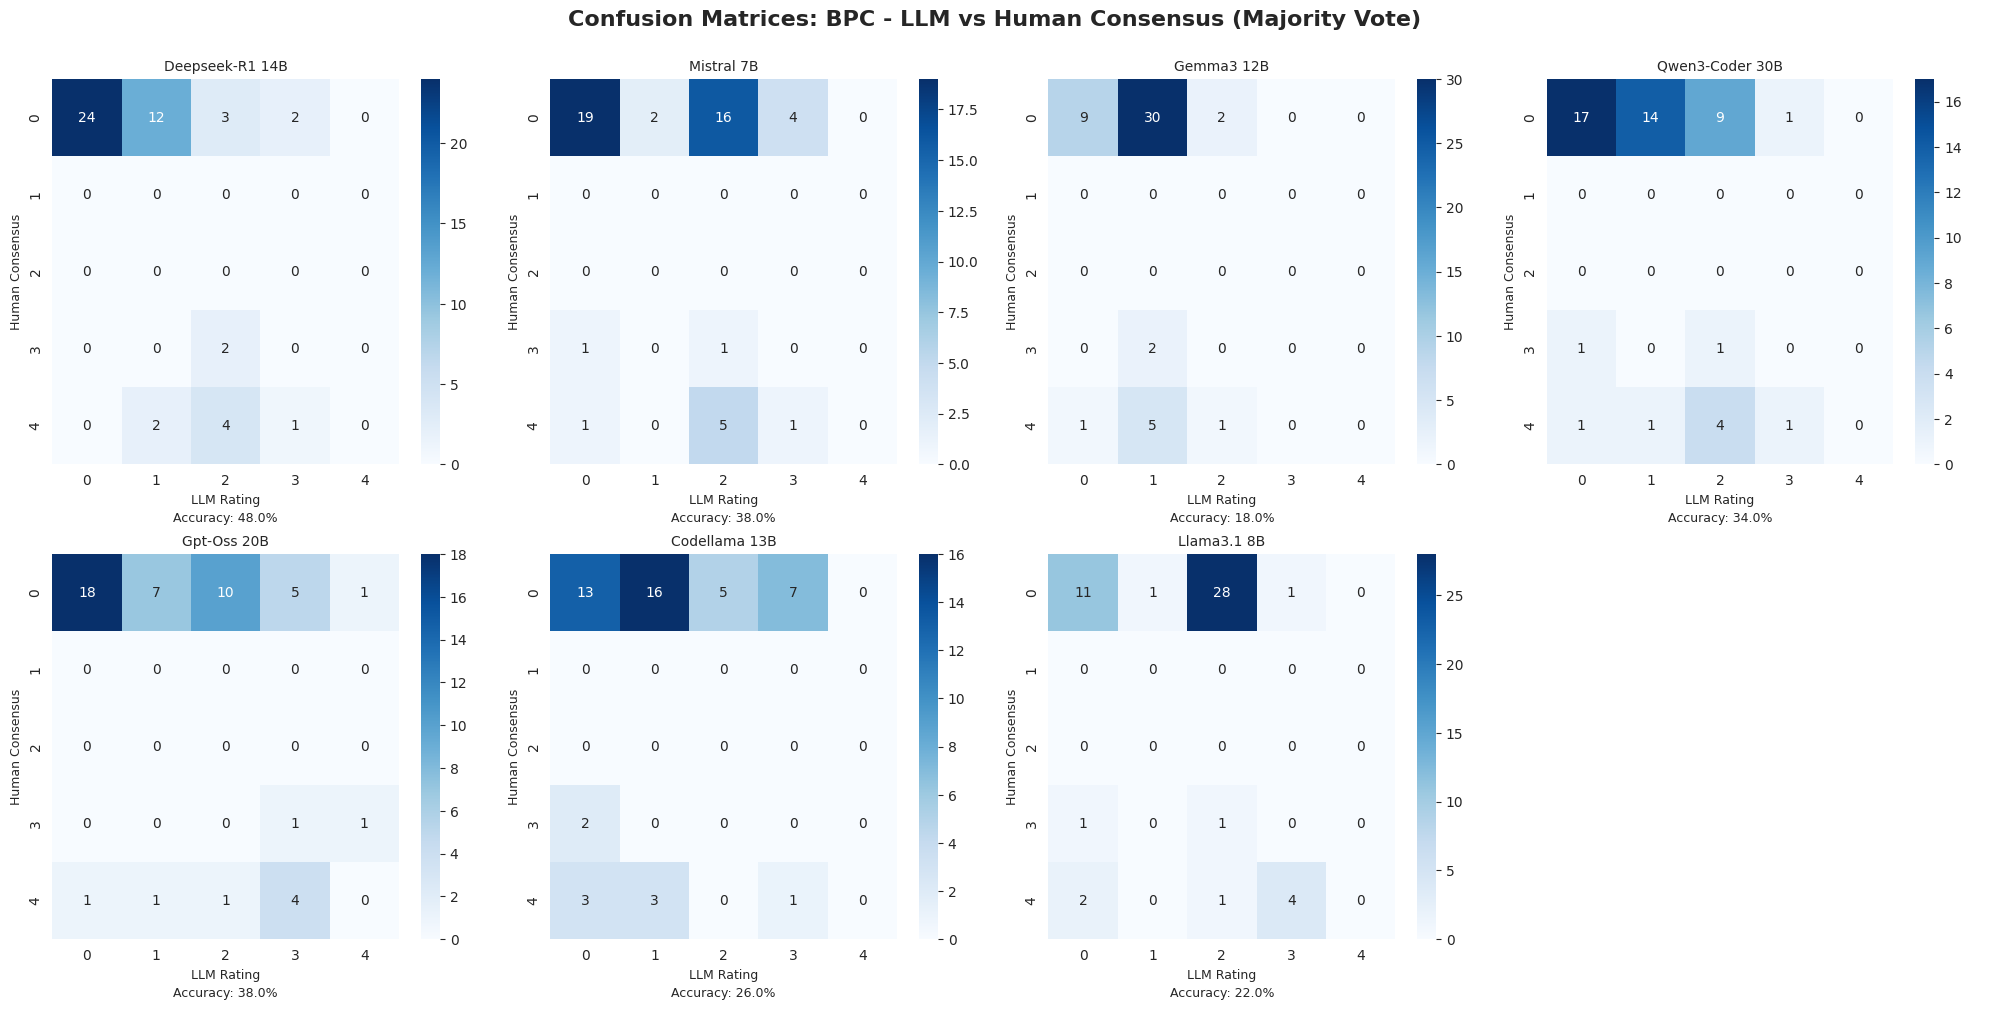

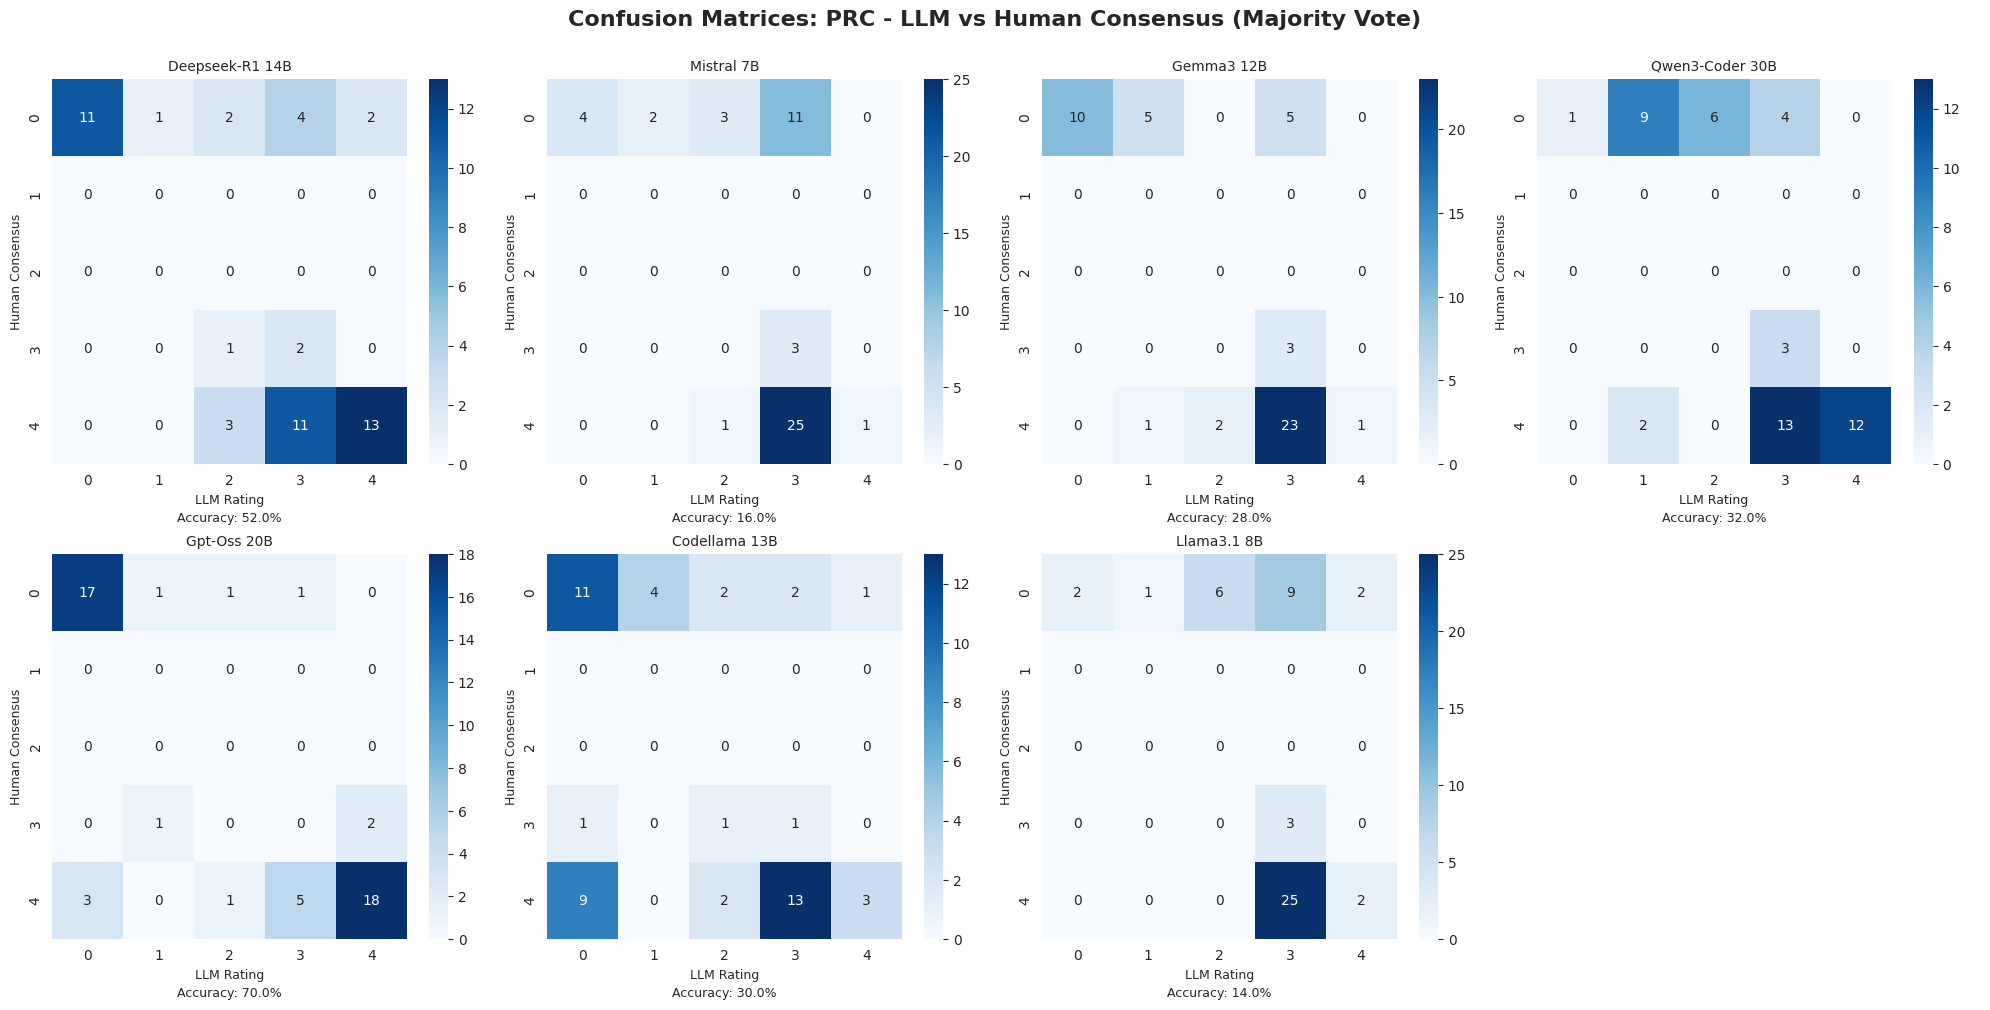

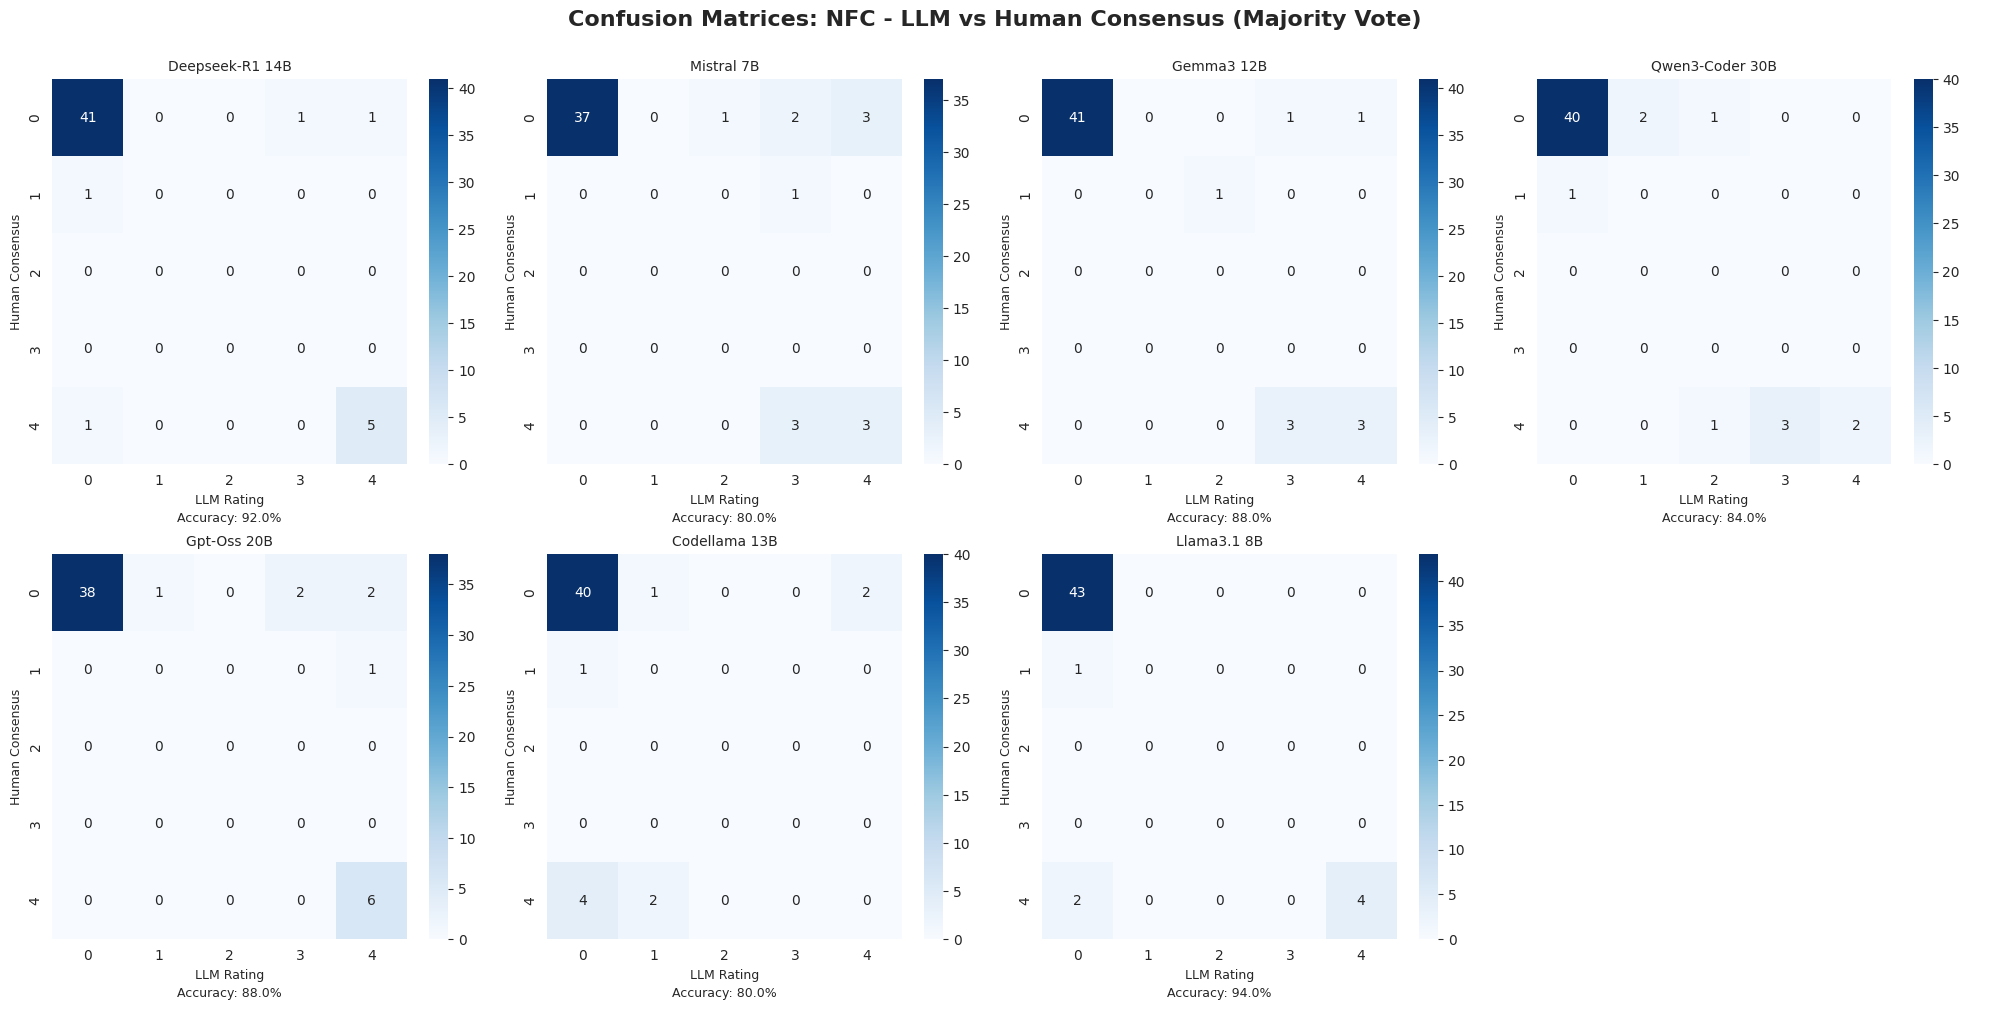

In [10]:
def get_majority_vote(df, commit_hash, category, human_annotators):
    """Get majority vote from human annotators for a specific commit and category."""
    ratings = df[(df['hash'] == commit_hash) & (df['annotator_id'].isin(human_annotators))][category]
    if len(ratings) == 0:
        return np.nan
    return ratings.mode()[0] if len(ratings.mode()) > 0 else ratings.iloc[0]

# Create human consensus (majority vote)
unique_commits = validation_df['hash'].unique()

# For each category, create confusion matrices
for category in classification_cols:
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for idx, llm in enumerate(llm_annotators):
        # Prepare data
        y_human = []
        y_llm = []
        
        for commit in unique_commits:
            # Get human consensus
            human_consensus = get_majority_vote(validation_df, commit, category, human_annotators)
            # Get LLM rating
            llm_rating = validation_df[(validation_df['hash'] == commit) & 
                                       (validation_df['annotator_id'] == llm)][category].values
            
            if len(llm_rating) > 0 and not np.isnan(human_consensus):
                y_human.append(int(human_consensus))
                y_llm.append(int(llm_rating[0]))
        
        # Create confusion matrix
        cm = confusion_matrix(y_human, y_llm, labels=[0, 1, 2, 3, 4])
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
        axes[idx].set_title(f'{llm.replace("_", " ").title()}', fontsize=10)
        axes[idx].set_xlabel('LLM Rating', fontsize=9)
        axes[idx].set_ylabel('Human Consensus', fontsize=9)
        
        # Calculate accuracy
        accuracy = np.trace(cm) / np.sum(cm) * 100
        axes[idx].text(0.5, -0.15, f'Accuracy: {accuracy:.1f}%', 
                      ha='center', transform=axes[idx].transAxes, fontsize=9)
    
    # Hide last subplot if odd number of LLMs
    if len(llm_annotators) < 8:
        axes[-1].axis('off')
    
    fig.suptitle(f'Confusion Matrices: {category.upper()} - LLM vs Human Consensus (Majority Vote)', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(f'figures/confusion_matrix_{category}.png', dpi=300, bbox_inches='tight')
    plt.show()

## 10. Statistical Summary

Create comprehensive statistical summary of results.

In [11]:
# Combine all metrics
summary_data = []

for llm in llm_annotators:
    # Krippendorff's Alpha (average across categories)
    avg_krippendorff = krippendorff_df[krippendorff_df['LLM'] == llm]['Krippendorff_Alpha'].mean()
    
    # Cohen's Kappa (average across all human annotators and categories)
    avg_cohens = cohens_kappa_df[cohens_kappa_df['LLM'] == llm]['Cohens_Kappa'].mean()
    
    # Standard deviation
    std_krippendorff = krippendorff_df[krippendorff_df['LLM'] == llm]['Krippendorff_Alpha'].std()
    std_cohens = cohens_kappa_df[cohens_kappa_df['LLM'] == llm]['Cohens_Kappa'].std()
    
    summary_data.append({
        'LLM': llm,
        'Avg_Krippendorff_Alpha': avg_krippendorff,
        'Std_Krippendorff': std_krippendorff,
        'Avg_Cohens_Kappa': avg_cohens,
        'Std_Cohens': std_cohens,
        'Overall_Score': (avg_krippendorff + avg_cohens) / 2
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Overall_Score', ascending=False)

print("Statistical Summary of Inter-Annotator Agreement:")
print("="*100)
display(summary_df.round(4))

# Interpretation
print("\n\nInterpretation Guidelines:")
print("-" * 100)
print("Krippendorff's Alpha:")
print("  • α ≥ 0.800: Good reliability")
print("  • 0.667 ≤ α < 0.800: Tentative conclusions possible")
print("  • α < 0.667: Insufficient reliability")
print("\nCohen's Kappa:")
print("  • κ > 0.80: Almost perfect agreement")
print("  • 0.60-0.80: Substantial agreement")
print("  • 0.40-0.60: Moderate agreement")
print("  • 0.20-0.40: Fair agreement")
print("  • < 0.20: Slight/poor agreement")

Statistical Summary of Inter-Annotator Agreement:


,LLM,Avg_Krippendorff_Alpha,Std_Krippendorff,Avg_Cohens_Kappa,Std_Cohens,Overall_Score
4,gpt-oss_20b,0.6233,0.2067,0.5329,0.2118,0.5781
3,qwen3-coder_30b,0.6296,0.2378,0.4988,0.2593,0.5642
0,deepseek-r1_14b,0.6260,0.1860,0.5013,0.1981,0.5636
2,gemma3_12b,0.6007,0.2636,0.4810,0.2935,0.5408
6,llama3.1_8b,0.5587,0.2763,0.3996,0.3257,0.4792
1,mistral_7b,0.5379,0.2072,0.3147,0.2015,0.4263
5,codellama_13b,0.4594,0.2230,0.1919,0.2088,0.3257




Interpretation Guidelines:
----------------------------------------------------------------------------------------------------
Krippendorff's Alpha:
  • α ≥ 0.800: Good reliability
  • 0.667 ≤ α < 0.800: Tentative conclusions possible
  • α < 0.667: Insufficient reliability

Cohen's Kappa:
  • κ > 0.80: Almost perfect agreement
  • 0.60-0.80: Substantial agreement
  • 0.40-0.60: Moderate agreement
  • 0.20-0.40: Fair agreement
  • < 0.20: Slight/poor agreement


## 11. Analysis and Conclusions

### Key Findings

Based on the calculated metrics (Krippendorff's Alpha and Cohen's Kappa), we can assess whether LLMs can be considered reliable annotators for commit classification tasks.

**Analysis Framework:**
1. **Krippendorff's Alpha** measures overall reliability when combining each LLM with all 3 human annotators
2. **Cohen's Kappa** provides pairwise agreement between each LLM and individual human annotators
3. Both metrics account for chance agreement and are appropriate for ordinal Likert scale data

In [12]:
# Generate automated interpretation
best_llm = summary_df.iloc[0]
worst_llm = summary_df.iloc[-1]

print("AUTOMATED ANALYSIS")
print("=" * 100)
print(f"\n🏆 Best Performing LLM: {best_llm['LLM']}")
print(f"   • Average Krippendorff's Alpha: {best_llm['Avg_Krippendorff_Alpha']:.3f}")
print(f"   • Average Cohen's Kappa: {best_llm['Avg_Cohens_Kappa']:.3f}")
print(f"   • Overall Score: {best_llm['Overall_Score']:.3f}")

print(f"\n📊 Lowest Performing LLM: {worst_llm['LLM']}")
print(f"   • Average Krippendorff's Alpha: {worst_llm['Avg_Krippendorff_Alpha']:.3f}")
print(f"   • Average Cohen's Kappa: {worst_llm['Avg_Cohens_Kappa']:.3f}")
print(f"   • Overall Score: {worst_llm['Overall_Score']:.3f}")

# Count how many LLMs meet reliability thresholds
reliable_krippendorff = (summary_df['Avg_Krippendorff_Alpha'] >= 0.667).sum()
reliable_cohens = (summary_df['Avg_Cohens_Kappa'] >= 0.40).sum()

print(f"\n📈 Reliability Assessment:")
print(f"   • LLMs with tentative reliability (Krippendorff α ≥ 0.667): {reliable_krippendorff}/{len(llm_annotators)}")
print(f"   • LLMs with moderate+ agreement (Cohen's κ ≥ 0.40): {reliable_cohens}/{len(llm_annotators)}")

# Calculate consistency across categories
category_consistency = []
for category in classification_cols:
    cat_scores = cohens_kappa_df[cohens_kappa_df['Category'] == category.upper()]['Cohens_Kappa']
    category_consistency.append({
        'Category': category.upper(),
        'Mean_Kappa': cat_scores.mean(),
        'Std_Kappa': cat_scores.std()
    })

consistency_df = pd.DataFrame(category_consistency).sort_values('Mean_Kappa', ascending=False)

print(f"\n📊 Agreement by Classification Category:")
display(consistency_df.round(3))

# Overall conclusion
avg_all_krippendorff = summary_df['Avg_Krippendorff_Alpha'].mean()
avg_all_cohens = summary_df['Avg_Cohens_Kappa'].mean()

print(f"\n🎯 Overall Conclusions:")
print(f"   • Mean Krippendorff's Alpha across all LLMs: {avg_all_krippendorff:.3f}")
print(f"   • Mean Cohen's Kappa across all LLMs: {avg_all_cohens:.3f}")

if avg_all_krippendorff >= 0.667 and avg_all_cohens >= 0.40:
    conclusion = "✅ LLMs show TENTATIVE to MODERATE agreement with human annotators"
    reliability = "Can be used with caution for preliminary analysis, but human review recommended"
elif avg_all_krippendorff >= 0.500 or avg_all_cohens >= 0.30:
    conclusion = "⚠️  LLMs show FAIR agreement with human annotators"
    reliability = "Should NOT be used as sole annotators; require significant human oversight"
else:
    conclusion = "❌ LLMs show INSUFFICIENT agreement with human annotators"
    reliability = "NOT reliable for this annotation task; human annotation required"

print(f"\n{conclusion}")
print(f"   Recommendation: {reliability}")

AUTOMATED ANALYSIS

🏆 Best Performing LLM: gpt-oss_20b
   • Average Krippendorff's Alpha: 0.623
   • Average Cohen's Kappa: 0.533
   • Overall Score: 0.578

📊 Lowest Performing LLM: codellama_13b
   • Average Krippendorff's Alpha: 0.459
   • Average Cohen's Kappa: 0.192
   • Overall Score: 0.326

📈 Reliability Assessment:
   • LLMs with tentative reliability (Krippendorff α ≥ 0.667): 0/7
   • LLMs with moderate+ agreement (Cohen's κ ≥ 0.40): 4/7

📊 Agreement by Classification Category:


,Category,Mean_Kappa,Std_Kappa
0,BFC,0.605,0.120
3,NFC,0.588,0.227
2,PRC,0.392,0.169
1,BPC,0.084,0.109



🎯 Overall Conclusions:
   • Mean Krippendorff's Alpha across all LLMs: 0.577
   • Mean Cohen's Kappa across all LLMs: 0.417

⚠️  LLMs show FAIR agreement with human annotators
   Recommendation: Should NOT be used as sole annotators; require significant human oversight


## 12. Export Results

Save all computed metrics and visualizations for further use.

In [13]:
# Export results to CSV files
krippendorff_df.to_csv('results/krippendorff_alpha_results.csv', index=False)
cohens_kappa_df.to_csv('results/cohens_kappa_results.csv', index=False)
summary_df.to_csv('results/summary_statistics.csv', index=False)

print("✓ Results exported successfully:")
print("  • results/krippendorff_alpha_results.csv")
print("  • results/cohens_kappa_results.csv")
print("  • results/summary_statistics.csv")
print("\nVisualizations saved:")
print("  • figures/krippendorff_alpha_analysis.png")
print("  • figures/cohens_kappa_analysis.png")
print("  • figures/confusion_matrix_bfc.png")
print("  • figures/confusion_matrix_bpc.png")
print("  • figures/confusion_matrix_prc.png")
print("  • figures/confusion_matrix_nfc.png")

✓ Results exported successfully:
  • results/krippendorff_alpha_results.csv
  • results/cohens_kappa_results.csv
  • results/summary_statistics.csv

Visualizations saved:
  • figures/krippendorff_alpha_analysis.png
  • figures/cohens_kappa_analysis.png
  • figures/confusion_matrix_bfc.png
  • figures/confusion_matrix_bpc.png
  • figures/confusion_matrix_prc.png
  • figures/confusion_matrix_nfc.png
